# Obesity Rate Correlation Analysis

* The analysis will encompass data from the states of California, Ohio, and South Carolina.
* The objective is to find if there is correlation between obesity rate and the following measurements: 
    * Median household income
    * % With access to exercise opportunities
    * % of physically inactive
    * Primary care physicians rate
    * High School Unemployment rate
    * Unemployed rate
    

In [1]:
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
from pprint import pprint
from api_key import g_key 
import json
import gmaps
import glob


In [2]:
# Countyhealthrankings data for California, Ohio and South Carolina
# source https://www.countyhealthrankings.org/

path = "./CountyHealthRankings"
all_files = glob.glob(path + "/*.csv")

# Read all csv files in folder and append to create one dataframe

all_states = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_states.append(df)
frame = pd.concat(all_states, axis=0, ignore_index=True)
frame.head()
states_health_df = frame[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
states_health_df.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,33000,28,21,88.0,91.0,89.0,2.5
1,33001,29,23,87.0,64.0,88.0,2.5
2,33003,27,22,81.0,92.0,94.0,2.5
3,33005,30,19,75.0,68.0,89.0,2.5
4,33007,34,26,74.0,114.0,92.0,3.2


In [3]:
# Census URL to collect median household income for 2018 for every state and county

url = "https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*"
print(url)

https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*


## Data Cleaning
* Cleaning Data from the US Census and countyhealthrankings for the following states:
    * California 
    * Texas
    * Florida

In [4]:
# Converting census request into a DataFrame

census_data = requests.get(url).json()
census_df = pd.DataFrame(census_data).drop([0,])
census_df.head()

,0,1,2,3
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [5]:
# Renaming column headers from US Census data

rename_census_df = census_df.rename(columns = {0:"County and State",
                             1:"Median Income",
                             2:"State Code",
                             3: "County Code"})
rename_census_df.head()

,County and State,Median Income,State Code,County Code
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [6]:
# Combining State and County Code in order to merge the DataFrame with the Countyhealthrankings
# DataFrame

rename_census_df["FIPS"] = rename_census_df["State Code"].astype(str) + rename_census_df["County Code"].astype(str)
rename_census_df.head()

,County and State,Median Income,State Code,County Code,FIPS
1,"Washington County, Mississippi",30834,28,151,28151
2,"Perry County, Mississippi",39007,28,111,28111
3,"Choctaw County, Mississippi",37203,28,019,28019
4,"Itawamba County, Mississippi",40510,28,057,28057
5,"Carroll County, Mississippi",43060,28,015,28015


In [7]:
# Splitting the County and State column and creating two new columns for "County" and "State"
# to filter by California, Ohio and South Carolina

county_state = rename_census_df["County and State"].str.split(",", n = 0, expand = True) 
rename_census_df["County"]= county_state[0]
rename_census_df["State"] = county_state[1]
rename_census_df.head()

,County and State,Median Income,State Code,County Code,FIPS,County,State
1,"Washington County, Mississippi",30834,28,151,28151,Washington County,Mississippi
2,"Perry County, Mississippi",39007,28,111,28111,Perry County,Mississippi
3,"Choctaw County, Mississippi",37203,28,019,28019,Choctaw County,Mississippi
4,"Itawamba County, Mississippi",40510,28,057,28057,Itawamba County,Mississippi
5,"Carroll County, Mississippi",43060,28,015,28015,Carroll County,Mississippi


In [8]:
# Create a copy of the states_df to format FIPS column

states_health_df_copy = states_health_df.copy()
reformat_fips = states_health_df_copy['FIPS'].apply('{:0>5}'.format)
fips_df = pd.DataFrame(reformat_fips)
states_health_df_copy["FIPS"] = fips_df
states_health_df_copy.head()


,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,33000,28,21,88.0,91.0,89.0,2.5
1,33001,29,23,87.0,64.0,88.0,2.5
2,33003,27,22,81.0,92.0,94.0,2.5
3,33005,30,19,75.0,68.0,89.0,2.5
4,33007,34,26,74.0,114.0,92.0,3.2


In [9]:
# Merge US Census data frame 'states_health_df_copy' with County Health Rankings Data 'indiciators_data' 

indicators_data = rename_census_df[["County and State","Median Income","FIPS","State","County"]].sort_values(by=['FIPS'])
all_states_merge = pd.merge(states_health_df_copy,indicators_data,on="FIPS",how="left")
all_states_merge.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County
0,33000,28,21,88.0,91.0,89.0,2.5,NaN,NaN,NaN,NaN
1,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap County
2,33003,27,22,81.0,92.0,94.0,2.5,"Carroll County, New Hampshire",61116,New Hampshire,Carroll County
3,33005,30,19,75.0,68.0,89.0,2.5,"Cheshire County, New Hampshire",63057,New Hampshire,Cheshire County
4,33007,34,26,74.0,114.0,92.0,3.2,"Coos County, New Hampshire",45696,New Hampshire,Coos County


In [10]:
# Export dataframe to CSV

clean_all_states = all_states_merge.dropna()
clean_all_states.to_csv('./final_dataframe.csv', index=False)

# Correlation and Regression Analysis

### Florida - Obesity Rate vs. % Physically Inactive

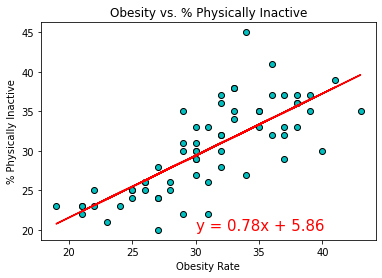

The r-squared value is: 0.7628220794645032


In [54]:
fl_analysis = clean_all_states.loc[clean_all_states["State"] == " Florida" ]
fl_obesity_rate = fl_analysis["% Adults with Obesity"]
fl_physical = fl_analysis["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_physical)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_physical,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.savefig("output_diagrams/florida_obesity_physical_activity.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. % With Access to Exercise Opportunities

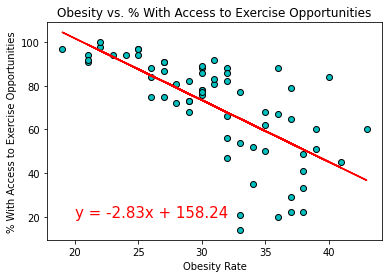

The r-squared value is: -0.6827460730267716


In [65]:
fl_exercise = fl_analysis["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_exercise)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_exercise,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.savefig("output_diagrams/florida_obesity_exercise_opportunities.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. Primary Care Physicians Rate

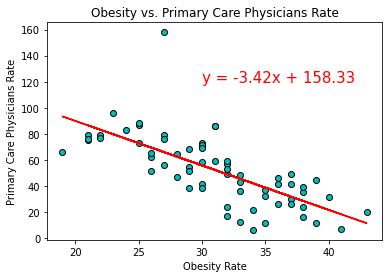

The r-squared value is: -0.7060608869434568


In [76]:
fl_physician = fl_analysis["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_physician)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_physician,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,120),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.savefig("output_diagrams/florida_obesity_primary_care.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. High School Graduation Rate

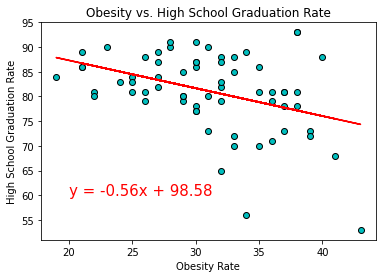

The r-squared value is: -0.39257277154130893


In [55]:
fl_graduation = fl_analysis["High School Graduation Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_graduation)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_graduation,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,60),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.savefig("output_diagrams/florida_obesity_hs_graduation.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. % Unemployed

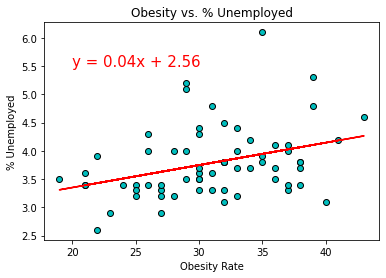

The r-squared value is: 0.35124253540383915


In [56]:
fl_unemployed = fl_analysis["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_unemployed)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_unemployed,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,5.5),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.savefig("output_diagrams/florida_obesity_unemployed.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Florida - Obesity Rate vs. Median Household Income

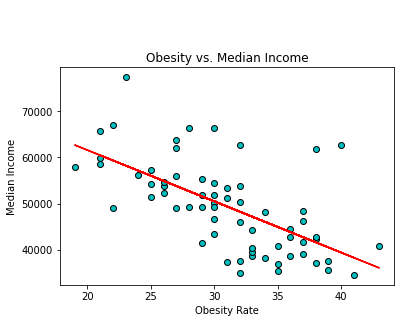

The r-squared value is: -0.6267710288163144


In [57]:
fl_median_income = fl_analysis["Median Income"].astype(int)

(slope, intercept, rvalue, pvalue, stderr) = linregress(fl_obesity_rate, fl_median_income)
regress_values = fl_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(fl_obesity_rate,fl_median_income,color="c",edgecolors="black")
plt.plot(fl_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,90000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income")
plt.savefig("output_diagrams/florida_obesity_median_income.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. % Physically Inactive

In [15]:
texas_df = clean_all_states.loc[clean_all_states["State"] == " Texas" ]

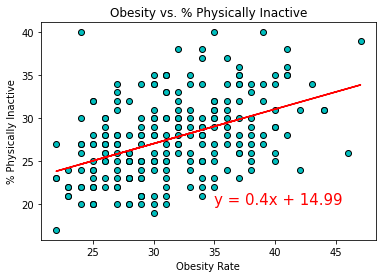

The r-squared value is: 0.4492396454422658


In [58]:
texas_obesity_rate = texas_df["% Adults with Obesity"]
texas_physical = texas_df["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_physical)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_physical,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(35,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.savefig("output_diagrams/texas_obesity_physical_activity.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. % With Access to Exercise Opportunities

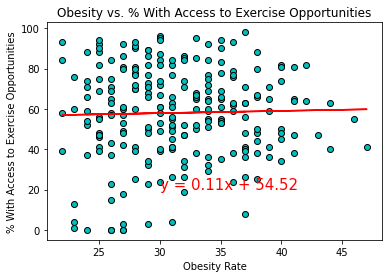

The r-squared value is: 0.026004282262443435


In [59]:
texas_exercise = texas_df["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_exercise)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_exercise,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.savefig("output_diagrams/texas_obesity_exercise_opportunities.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. Primary Care Physicians Rate

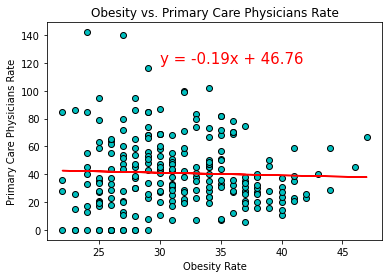

The r-squared value is: -0.038814626067330125


In [66]:
texas_physician = texas_df["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_physician)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_physician,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,120),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.savefig("output_diagrams/texas_obesity_primary_care.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. High School Graduation Rate

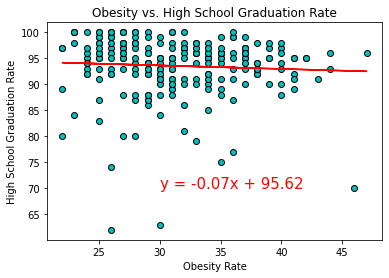

The r-squared value is: -0.061271310454999346


In [67]:
texas_education = texas_df["High School Graduation Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_education)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_education,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,70),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.savefig("output_diagrams/texas_obesity_hs_graduation.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. % Unemployed

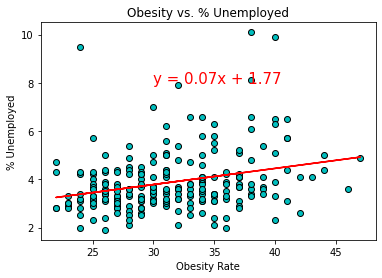

The r-squared value is: 0.28119749582234616


In [68]:
texas_unemployed = texas_df["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_unemployed)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_unemployed,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,8),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.savefig("output_diagrams/texas_obesity_unemployed.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Texas - Obesity Rate vs. Median Income

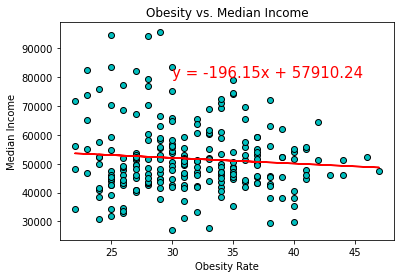

The r-squared value is: -0.0858233192832307


In [69]:
texas_median_income = texas_df["Median Income"].astype(int)

(slope, intercept, rvalue, pvalue, stderr) = linregress(texas_obesity_rate, texas_median_income)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(texas_obesity_rate,texas_median_income,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,80000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income")
plt.savefig("output_diagrams/texas_obesity_median_income.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % Physically Inactive

In [22]:
california_df = clean_all_states.loc[clean_all_states["State"] == " California" ].dropna()

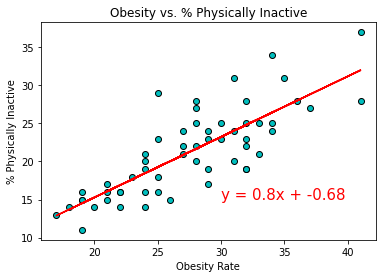

The r-squared value is: 0.800005240411173


In [70]:
california_obesity_rate = california_df["% Adults with Obesity"]
california_physical = california_df["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_physical)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_physical,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,15),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.savefig("output_diagrams/california_obesity_physical_activity.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % With Access to Exercise Opportunities

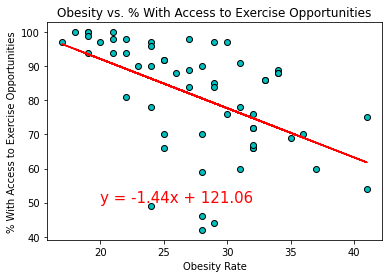

The r-squared value is: -0.5129692276214599


In [71]:
california_exercise = california_df["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_exercise)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_exercise,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(20,50),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.savefig("output_diagrams/california_obesity_exercise.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % Primary Care Physicians Rate

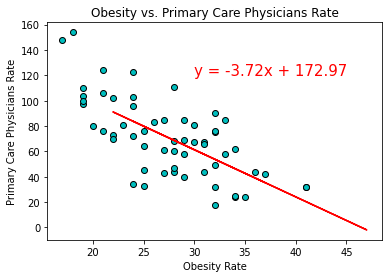

The r-squared value is: -0.6885447168207459


In [72]:
california_physician = california_df["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_physician)
regress_values = texas_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_physician,color="c",edgecolors="black")
plt.plot(texas_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,120),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.savefig("output_diagrams/california_obesity_primary_care.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % High School Graduation

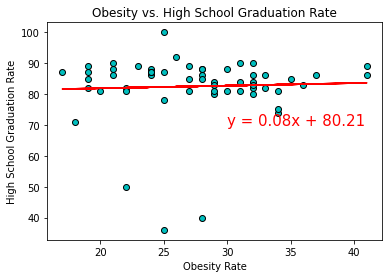

The r-squared value is: 0.044062706452217854


In [73]:
california_education = california_df["High School Graduation Rate"].dropna()

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_education)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_education,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,70),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.savefig("output_diagrams/california_obesity_hs_graduation.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. % Unemployed

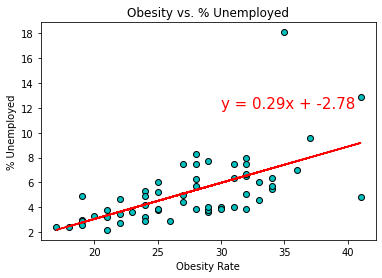

The r-squared value is: 0.6228089181233846


In [74]:
california_unemployed = california_df["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_unemployed)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_unemployed,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,12),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.savefig("output_diagrams/california_obesity_unemployed.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### California - Obesity Rate vs. Median Income

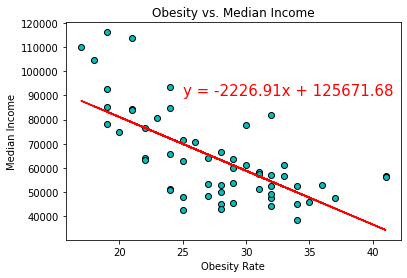

The r-squared value is: -0.6711330059279156


In [75]:
california_median_income = california_df["Median Income"].astype(int)

(slope, intercept, rvalue, pvalue, stderr) = linregress(california_obesity_rate, california_median_income)
regress_values = california_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(california_obesity_rate,california_median_income,color="c",edgecolors="black")
plt.plot(california_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(25,90000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income")
plt.savefig("output_diagrams/california_obesity_median_income.png")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

### Top 100 Counties with Highest Obesity Rate Analysis

### Heatmap for Obesity Rate

In [29]:
# Geocodes collected from Socrata
geocode = pd.read_csv("./Geocodes_USA_with_Counties.csv")

# Creating a dataframe for the geocodes
lat_lng = pd.DataFrame(geocode)

In [30]:
# Selecting only needed columns from the lat_lng dataframe 'state','latitude','longitude','county'
all_states_lat_lng = lat_lng.iloc[:,[2,3,4,5]]

# Renameing 'county' to 'County' in order to merge the dataframe with another dataframe
rename_lat_lng = all_states_lat_lng.rename(columns = {"county":"County"})
rename_lat_lng.head()

,state,latitude,longitude,County
0,NY,40.81,-73.04,Suffolk
1,NY,40.81,-73.04,Suffolk
2,PR,18.16,-66.72,Adjuntas
3,PR,18.38,-67.18,NaN
4,PR,18.43,-67.15,Aguadilla


In [31]:
# Removing the word county from the County Health Rankings dataframe 'all_states_merge' in order to merge with geocodes from Socrata

county_series = all_states_merge["County"]
strip_county = county_series.str.rstrip('County')
county_name = strip_county.str.rstrip(' ')
county_name.head()

0         NaN
1     Belknap
2     Carroll
3    Cheshire
4        Coos
Name: County, dtype: object

In [32]:
# Creating a copy of the dataframe in order to replace the "County" column with only the name of the County
clean_all_states_copy = clean_all_states.copy()
clean_all_states_copy["County"] = county_name
clean_all_states_copy.head()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County
1,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap
2,33003,27,22,81.0,92.0,94.0,2.5,"Carroll County, New Hampshire",61116,New Hampshire,Carroll
3,33005,30,19,75.0,68.0,89.0,2.5,"Cheshire County, New Hampshire",63057,New Hampshire,Cheshire
4,33007,34,26,74.0,114.0,92.0,3.2,"Coos County, New Hampshire",45696,New Hampshire,Coos
5,33009,24,19,90.0,197.0,95.0,2.1,"Grafton County, New Hampshire",63153,New Hampshire,Grafton


In [33]:
# Merging all data from the US Census, County Health Rankings and Socrata

data_merge = pd.merge(clean_all_states_copy,rename_lat_lng,on="County",how="left")
data_merge.head(3)

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude
0,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.33,-71.29
1,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.44,-71.47
2,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.33,-71.23


In [34]:
# Dropping duplicates from the dataset

clean_dataset = data_merge.dropna()
drop_duplicates = clean_dataset.drop_duplicates(subset="County")
drop_duplicates.head(2)

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude
0,33001,29,23,87.0,64.0,88.0,2.5,"Belknap County, New Hampshire",68368,New Hampshire,Belknap,NH,43.33,-71.29
19,33003,27,22,81.0,92.0,94.0,2.5,"Carroll County, New Hampshire",61116,New Hampshire,Carroll,NH,43.83,-71.47


In [35]:
figure = gmaps.figure()


lat_lng = drop_duplicates[["latitude","longitude"]]
obesity = drop_duplicates["% Adults with Obesity"]

# Create heat layer
heat_layer = gmaps.heatmap_layer(lat_lng, weights=obesity, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=.8)


# Add layer
figure.add_layer(heat_layer)

# Display figure
figure

Figure(layout=FigureLayout(height='420px'))

### Top 100 Counties with the highest obesity rate analysis

In [99]:
sort_obesity = clean_all_states.sort_values(by=["% Adults with Obesity"],ascending=False).reset_index()
drop_index = sort_obesity.drop(['index'], axis=1)
top_100_obesity = drop_index[:100]
top_100_series = top_100_obesity["County"]
top_100_strip_county = top_100_series.str.rstrip('County')
top_100_county_name = top_100_strip_county.str.rstrip(' ')
top_100_obesity_copy = top_100_obesity.copy()
top_100_obesity_copy["County"] = top_100_county_name
top_100_obesity_merge = pd.merge(top_100_obesity_copy,rename_lat_lng,on="County",how="left")
clean_100 = top_100_obesity_merge.dropna()
drop_100_duplicates = clean_100.drop_duplicates(subset="County")
drop_100_duplicates.head(2)

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State,County,state,latitude,longitude
0,13301,58,28,8.0,57.0,88.0,5.0,"Warren County, Georgia",34730,Georgia,Warren,NJ,40.91,-74.83
143,28063,54,35,61.0,55.0,88.0,13.3,"Jefferson County, Mississippi",20188,Mississippi,Jefferson,NY,43.97,-75.91


In [100]:
figure = gmaps.figure()


lat_lng_100 = drop_100_duplicates[["latitude","longitude"]]
obesity_100 = drop_100_duplicates["% Adults with Obesity"]

# Create heat layer
heat_layer = gmaps.heatmap_layer(lat_lng_100, weights=obesity_100, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=.8)


# Add layer
figure.add_layer(heat_layer)

# Display figure
figure

Figure(layout=FigureLayout(height='420px'))

In [101]:
top_100_obesity.describe()

,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
count,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,44.94000,33.480000,46.510000,36.41000,86.020000,5.307000
std,2.82421,6.015938,22.472652,19.75358,7.441326,1.796532
min,42.00000,19.000000,2.000000,8.00000,53.000000,2.100000
25%,43.00000,30.000000,31.000000,21.75000,82.000000,4.175000
50%,44.00000,33.000000,48.500000,35.00000,86.000000,5.100000
75%,46.00000,37.250000,64.000000,45.25000,91.000000,5.825000
max,58.00000,50.000000,100.000000,122.00000,99.000000,13.300000


In [103]:
top_100_obesity["State"].value_counts()

 Mississippi       15
 Arkansas          10
 Alabama           10
 Georgia           10
 Louisiana          9
 North Carolina     8
 Texas              6
 Virginia           4
 Wisconsin          3
 Tennessee          3
 Kentucky           3
 South Carolina     3
 West Virginia      2
 Iowa               2
 Oklahoma           2
 Florida            1
 Missouri           1
 Indiana            1
 Alaska             1
 Maryland           1
 Kansas             1
 North Dakota       1
 Oregon             1
 Nebraska           1
 Michigan           1
Name: State, dtype: int64

# IGNORE CODES BELOW THIS CELL

In [36]:
# selected_counties = lat_lng.loc[(lat_lng["state"]=="OH") | (lat_lng["state"]=="CA") | (lat_lng["state"]=="SC")]
# counties_df = selected_counties.iloc[:,[2,3,4,5,10]]

In [37]:
# Filtering data for the states of California, Ohio and South Carolina
# Selecting only needed columns for "County and State","Median Income","State and County Code", and "State"
# selected_states = []
# clean_data = new_df[["County and State","Median Income","FIPS","State","County"]].sort_values(by=['FIPS'])
# states = [" California"," Texas"," Florida"]
# selected_states = clean_data.loc[(clean_data["State"]==" California") | (clean_data["State"]==" Texas") | (clean_data["State"]==" Florida") ]
# selected_states.head()

In [38]:
# create a copy of the selected_states DataFrame in order to cast the FIPS and Median Income columns as integer

# selected_states_copy = selected_states.copy()
# selected_states_copy["FIPS"] = selected_states["FIPS"].astype(int)
# selected_states_copy["Median Income"] = selected_states["Median Income"].astype(int)
# selected_states_copy.dtypes

In [39]:
# Read all csv files for California, Ohio and South Carolina.
# Extract only columns needed for analysis

# california_df = pd.read_csv(csvpath_california)
# ohio_df = pd.read_csv(csvpath_ohio)
# south_carolina_df = pd.read_csv(csvpath_south_carolina)

# ca_health_df = california_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
# ohio_health_df = ohio_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
# south_carolina_health_df = south_carolina_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]


In [40]:
# Concatenating all health data from countyhealth rankings for the three states into one DataFrame

# all_states = [ca_health_df,ohio_health_df,south_carolina_health_df]
# state_health_df = pd.concat(all_states)
# state_health_df.head()

In [41]:
# state_health_df.astype({'FIPS': 'str'}).dtypes

In [42]:
# Add 0 to the front of State/County code
# Used apply function along with format. Apply passes a function and applies it to every value in the series. 
# {:0>5}'.format | padding and aligning strings. :0 refers to the character we want to use to pad, in this case 0. 
# > tells it to align to the right. The 5 is the length of the returned character/digit. 
# In this case since the FIPS is only 4 digits this will apply one 0 to the front, making it a total of 5 digits
# https://www.w3resource.com/python/python-format.php
# https://www.geeksforgeeks.org/python-pandas-apply/

# format_FIPS = state_health_df['FIPS'].apply('{:0>5}'.format)

In [43]:
# Converting the formated FIPS to a DataFrame

# FIPS_df = pd.DataFrame(format_FIPS)

In [44]:
# Replacing the formatted FIPS column to the DataFrame

# state_health_df["FIPS"] = FIPS_df
# state_health_df.head()

In [45]:
# state_health_df.dtypes
# state_health_df_copy = state_health_df.copy()
# state_health_df_copy["FIPS"] = state_health_df["FIPS"].astype(int)
# state_health_df_copy.dtypes


In [46]:
# Merge data from the US census and countyhealthrankings into one DataFrame and drop NA

# merged_df = pd.merge(state_health_df_copy,selected_states_copy,on="FIPS",how="left")
# merged_df.dropna()

In [47]:
# group_counties = counties_df.groupby("county").max().reset_index().dropna()
# group_counties.head()

In [48]:
# merged_df_copy = merged_df.copy()
# selected_states_series = merged_df_copy["County"]
# strip_county = selected_states_series.str.rstrip('County')
# strip_space = strip_county.str.rstrip(' ')
# strip_space

In [49]:
# merged_df_copy["County"] = strip_space
# merged_df_copy.dropna().head()

In [50]:
# group_counties_rename = group_counties.rename(columns = {"county":"County"})
# group_counties_rename.head()

In [51]:
# group_counties_rename_copy = group_counties_rename.copy()
# group_counties_rename_copy["County"] = group_counties_rename["County"].astype(str)
# # group_counties_rename_copy["Median Income"] = group_counties_rename["Median Income"].astype(int)
# group_counties_rename_copy.dtypes

# All States

## Obesity vs. % Physically Inactive

In [ ]:
# states_obesity_rate = all_states_merge["% Adults with Obesity"]
# states_physical = all_states_merge["% Physically Inactive"]

# (slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, states_physical)
# regress_values = states_obesity_rate * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.scatter(states_obesity_rate,states_physical,color="c",edgecolors="black")
# plt.plot(states_obesity_rate,regress_values,"r-")
# plt.annotate(line_eq,(35,15),fontsize=15,color="red")
# plt.xlabel("Obesity Rate")
# plt.ylabel("% Physically Inactive")
# plt.title("Obesity vs. % Physically Inactive")
# plt.show()

# (print(f"The r-squared value is: {rvalue}"))

In [ ]:
# states_obesity_rate = all_states_merge["% Adults with Obesity"]
# states_exercise = all_states_merge["% With Access to Exercise Opportunities"]

# (slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, states_exercise)
# regress_values = states_obesity_rate * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.scatter(states_obesity_rate,states_exercise,color="c",edgecolors="black")
# plt.plot(states_obesity_rate,regress_values,"r-")
# plt.annotate(line_eq,(20,30),fontsize=15,color="red")
# plt.xlabel("Obesity Rate")
# plt.ylabel("% With Access to Exercise Opportunities")
# plt.title("Obesity vs. % With Access to Exercise Opportunities")
# plt.show()

# (print(f"The r-squared value is: {rvalue}"))

In [ ]:
# states_obesity_rate = all_states_merge["% Adults with Obesity"]
# states_physician = all_states_merge["Primary Care Physicians Rate"]

# (slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, states_physician)
# regress_values = states_obesity_rate * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.scatter(states_obesity_rate,states_physician,color="c",edgecolors="black")
# plt.plot(states_obesity_rate,regress_values,"r-")
# plt.annotate(line_eq,(30,20),fontsize=15,color="red")
# plt.xlabel("Obesity Rate")
# plt.ylabel("Primary Care Physicians Rate")
# plt.title("Obesity vs. Primary Care Physicians Rate")
# plt.show()

# (print(f"The r-squared value is: {rvalue}"))


In [ ]:
# states_obesity_rate = all_states_merge["% Adults with Obesity"]
# median_income = all_states_merge["Median Income"]

# (slope, intercept, rvalue, pvalue, stderr) = linregress(states_obesity_rate, median_income)
# regress_values = states_obesity_rate * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.scatter(states_obesity_rate,median_income,color="c",edgecolors="black")
# plt.plot(states_obesity_rate,regress_values,"r-")
# plt.annotate(line_eq,(26,90000),fontsize=15,color="red")
# plt.xlabel("Obesity Rate")
# plt.ylabel("Median Income")
# plt.title("Obesity vs. Median Income in Ohio")
# plt.show()

# (print(f"The r-squared value is: {rvalue}"))